In [41]:
!pip install pandas matplotlib opencv-python numpy tqdm SimpleITK pydicom scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 55.3 MB/s eta 0:00:0000:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 34.3 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import SimpleITK as sitk
import re
from PIL import Image

In [8]:
# Data preprocessing Functions
def histogram_match(src, dst):
    src = src * 255.0
    dst = dst * 255.0
    src = src.astype(np.uint8)
    dst = dst.astype(np.uint8)
    res = np.zeros_like(dst)

    cdf_src = np.zeros((3, 256))
    cdf_dst = np.zeros((3, 256))
    cdf_res = np.zeros((3, 256))
    kw = dict(bins=256, range=(0, 256), density=True)
    for ch in range(3):
        his_src, _ = np.histogram(src[:, :, ch], **kw)
        hist_dst, _ = np.histogram(dst[:, :, ch], **kw)
        cdf_src[ch] = np.cumsum(his_src)
        cdf_dst[ch] = np.cumsum(hist_dst)
        index = np.searchsorted(cdf_src[ch], cdf_dst[ch], side='left')
        np.clip(index, 0, 255, out=index)
        res[:, :, ch] = index[dst[:, :, ch]]
        his_res, _ = np.histogram(res[:, :, ch], **kw)
        cdf_res[ch] = np.cumsum(his_res)
    return res / 255.0


def bias_field_correction(image):
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    image = sitk.Cast(image, sitk.sitkFloat32)  # Cast to float32
    corrected_image = corrector.Execute(image)
    return corrected_image    
    
def z_score_normalization(image):
    # Convert the image to an array
    image_array = sitk.GetArrayFromImage(image)
    
    # Calclulate needed starts
    mean = np.mean(image_array)
    std = np.std(image_array)
    
    # Normalize the array and covert it back to an image
    normalized_array = (image_array - mean) / std
    normalized_image = sitk.GetImageFromArray(normalized_array)
    normalized_image.CopyInformation(image)
    return normalized_image    

def discretize_image(image, num_bins=32):
    # 
    image_array = sitk.GetArrayFromImage(image)
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    bin_width = (max_val - min_val) / num_bins
    discretized_array = np.floor((image_array - min_val) / bin_width).astype(np.int32)
    discretized_array[discretized_array >= num_bins] = num_bins - 1
    discretized_image = sitk.GetImageFromArray(discretized_array)
    discretized_image.CopyInformation(image)
    return discretized_image

def resize_image(image, new_size=(512, 512)):
    resampler = sitk.ResampleImageFilter()
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_spacing = [
        original_spacing[i] * (original_size[i] / new_size[i]) for i in range(2)
    ]
    
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(image.GetPixelIDValue())
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resized_image = resampler.Execute(image)
    return resized_image


def resize_image_opencv(image, new_size=(512, 512)):
    image_array = np.array(image)
    resized_image_array = cv2.resize(image_array, new_size, interpolation=cv2.INTER_CUBIC)
    resize_image = Image.fromarray(resized_image_array)
    return image

def convert_to_png(image):
    image_array = sitk.GetArrayFromImage(image)
    image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array) + 1e-6) * 255  # Normalize to 0-255

    image_pil = Image.fromarray(image_array)
    return image_pil
    
def preprocess_mri_image(src_path, option):
    dicom_data = pydicom.dcmread(src_path)
    pixel_spacing = list(dicom_data.PixelSpacing) + [dicom_data.SliceThickness]
    image = sitk.GetImageFromArray(dicom_data.pixel_array)
    image.SetSpacing(pixel_spacing)

    if option == 'dcm_to_png':
        dcm_to_png_image = convert_to_png(image) 
        dcm_to_png_image = resize_image_opencv(dcm_to_png_image)
        return dcm_to_png_image
    
    elif option == 'wo_bc':
        wo_bias_image = z_score_normalization(image)
        wo_bias_image = discretize_image(wo_bias_image)
        wo_bias_image = convert_to_png(wo_bias_image)
        wo_bias_image = resize_image_opencv(wo_bias_image)
        return wo_bias_image
    
    else:
        full_preprocessed_image = bias_field_correction(image)
        full_preprocessed_image = z_score_normalization(full_preprocessed_image)
        full_preprocessed_image = discretize_image(full_preprocessed_image)
        full_preprocessed_image = convert_to_png(full_preprocessed_image)
        full_preprocessed_image = resize_image_opencv(full_preprocessed_image)
        return full_preprocessed_image

def imread_imsave(src_path, dst_path, option):
    # Preprocess and save the image 
    image = preprocess_mri_image(src_path, option)
    image_array = np.array(image)
    cv2.imwrite(dst_path, image_array)
    
    

In [13]:
dicom_data = pydicom.dcmread("/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/2828203845/1.dcm")


In [24]:
arr = dicom_data.pixel_array

In [32]:
import os
dicom_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833"
dicom_files = [os.path.join(dicom_path,d_path) for d_path in os.listdir(dicom_path)]

len(dicom_files)

15

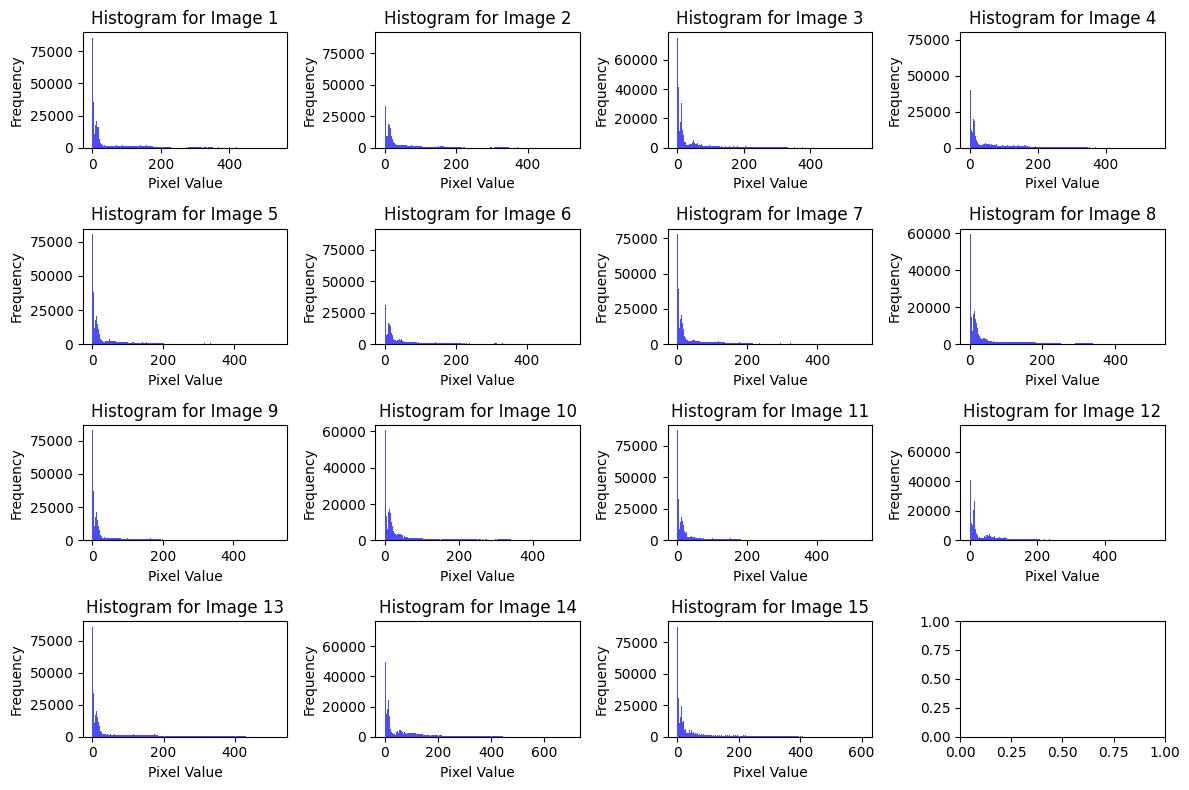

In [33]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# List of DICOM file paths
# Number of rows and columns in the grid
n_rows = 4
n_cols = 4

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the DICOM files and plot histograms
for i, file_path in enumerate(dicom_files):
    # Load the DICOM file
    dcm = pydicom.dcmread(file_path)
    
    # Extract pixel data
    pixel_array = dcm.pixel_array
    
    # Plot the histogram on the corresponding subplot
    axes[i].hist(pixel_array.ravel(), bins=256, range=[np.min(pixel_array), np.max(pixel_array)], color='blue', alpha=0.7)
    axes[i].set_title(f'Histogram for Image {i+1}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


# Reading CSV


In [34]:
rd = 'rsna-2024-lumbar-spine-degenerative-classification'


In [35]:
dfc = pd.read_csv(f'{rd}/train_label_coordinates.csv')

In [36]:
df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
df.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [37]:
df['series_description'].value_counts()

series_description
Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: count, dtype: int64

In [44]:
st_ids = df['study_id'].unique()
st_ids, len(st_ids)

(array([   4003253,    4646740,    7143189, ..., 4284048608, 4287160193,
        4290709089]),
 1975)

In [42]:
desc = list(df['series_description'].unique())
desc

['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

In [43]:
process_option = ['dcm_to_png', 'wo_bc', 'w_bc']

In [46]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


In [48]:
# option = "wo_bc"

# for idx, st_id in enumerate(tqdm(st_ids, total=len(st_ids))):
#     rows = df[df['study_id']==st_id] # get all the rows for 1 study
#     for ds in desc:
#         ds_ = ds.replace('/', '_')
#         rows_ = rows[rows['series_description']==ds] # within this study, select the rows in train_series_description that have this series_description
#         dst_dir_path = f'{option}_cvt_png/{st_id}/{ds_}'
#         os.makedirs(dst_dir_path, exist_ok=True)
#         all_imgs = []
    
#         for i, row in rows_.iterrows(): #go through all rows in this study (regardless of series_id)
#             imgs = glob.glob(f'{rd}/train_images/{row["study_id"]}/{row["series_id"]}/*.dcm')
#             imgs = sorted(imgs, key=natural_keys)
#             all_imgs.extend(imgs)
        
#         #basically get all the image paths for scans in this study, put it in all_imgs
#         if len(all_imgs) == 0:
#             print(f'{st_id} {ds_} has no images')
#             continue

        
#         if ds == 'Axial T2':
#             for j, impath in enumerate(all_imgs):
#                 dst_path = os.path.join(dst_dir_path, f'{j:03d}.png')
#                 imread_imsave(impath, dst_path, option)


#         elif ds == 'Sagittal T2/STIR':

#             step = len(all_imgs) / 10.0
#             st   = len(all_imgs) / 2.0 - 4.0 * step
#             end  = len(all_imgs) + 0.0001

#             for j, i in enumerate(np.arange(st, end, step)):
#                 dst_path = os.path.join(dst_dir_path, f'{j:03d}.png')
#                 ind2 = max(0, int((i- 0.5001).round()))
#                 imread_imsave(all_imgs[ind2], dst_path, option)


#         elif ds == 'Sagittal T1':
            
#             step = len(all_imgs) / 10.0
#             st   = len(all_imgs) / 2.0 - 4.0 * step
#             end  = len(all_imgs) + 0.0001

#             for j, i in enumerate(np.arange(st, end, step)):
#                 dst_path = os.path.join(dst_dir_path, f'{j:03d}.png')
#                 ind2 = max(0, int((i- 0.5001).round()))
#                 imread_imsave(all_imgs[ind2], dst_path, option)
                                                 


In [53]:
train_csv_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train.csv"
train_label_coordinates_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv"
train_series_desc_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv"
train_images_path = "/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images"

df_train = pd.read_csv(train_csv_path)
df_train_desc = pd.read_csv(train_label_coordinates_path)
df_train_desc['image_path'] = train_images_path + df_train_desc['study_id'].astype(str) +"/"+ df_train_desc['series_id'].astype(str) + "/"+ df_train_desc['instance_number'].astype(str) + ".dcm"

In [54]:
df_train_desc.head()

,study_id,series_id,instance_number,condition,level,x,y,image_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/home/tiny_ling/projects/kaggle/rsna-2024-lumb...


In [64]:
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='value')
df_train_melted.head()

,study_id,condition_level,value
0,4003253,spinal_canal_stenosis_l1_l2,Normal/Mild
1,4646740,spinal_canal_stenosis_l1_l2,Normal/Mild
2,7143189,spinal_canal_stenosis_l1_l2,Normal/Mild
3,8785691,spinal_canal_stenosis_l1_l2,Normal/Mild
4,10728036,spinal_canal_stenosis_l1_l2,Normal/Mild


In [70]:
def visualize_series(study_id,series_id):
    ncols = 4
    nrows = len(os.listdir(train_images_path + "/" + str(study_id) + "/" + str(series_id))) // n_cols
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    dicom_dir = train_images_path + "/" + str(study_id) + "/" + str(series_id)
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in sorted(os.listdir(dicom_dir)) if f.endswith('.dcm')]
    dicom_files.sort(key=lambda x: x.InstanceNumber)
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    for i,dicom_data in enumerate(dicom_files):
        pixel_spacing = list(dicom_data.PixelSpacing) + [dicom_data.SliceThickness]
        image = sitk.GetImageFromArray(dicom_data.pixel_array)
        image.SetSpacing(pixel_spacing)
        wo_bias_image = z_score_normalization(image)
        wo_bias_image = discretize_image(wo_bias_image)
        wo_bias_image = convert_to_png(wo_bias_image)
        image_array = np.array(wo_bias_image)
        resized_image_array = cv2.resize(image_array, (512,512), interpolation=cv2.INTER_CUBIC)
        axes[i].imshow(resized_image_array)
        axes[i].set_title(f'Instance # {i}')
        axes[i].axis('off')
        

    plt.tight_layout()
    plt.show()


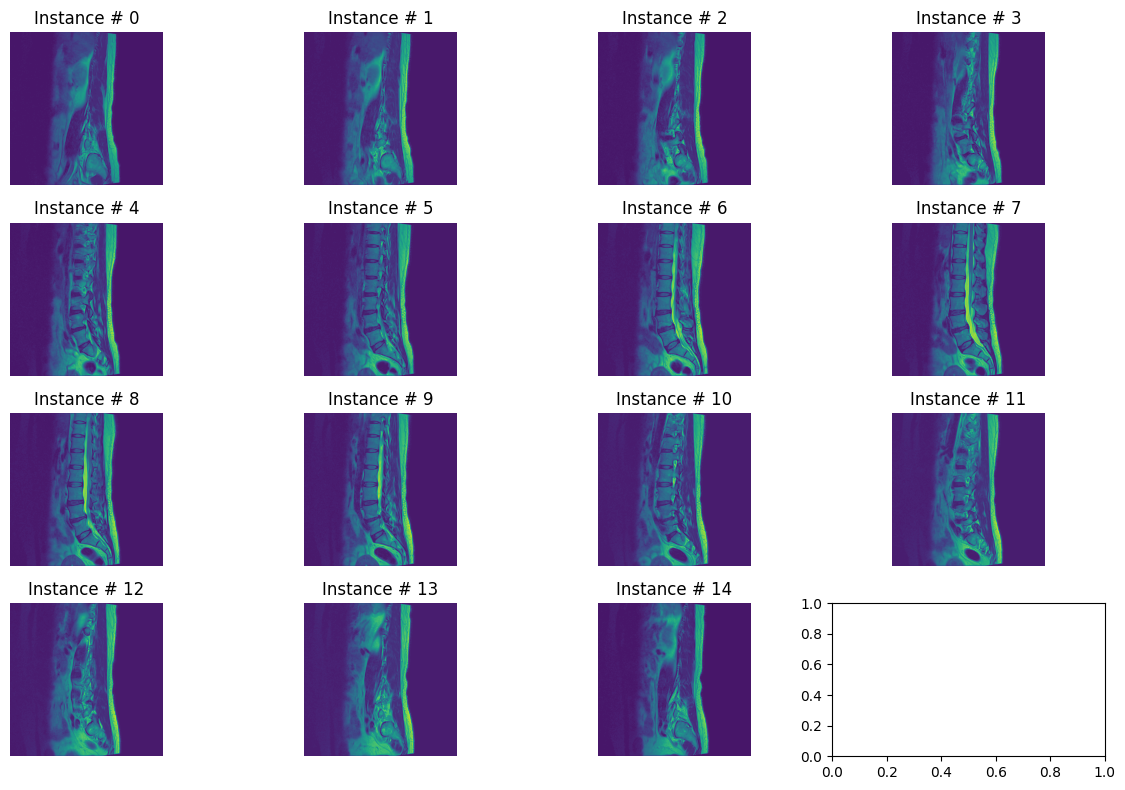

In [71]:
visualize_series(4003253,702807833)

In [69]:
import pydicom
import os

# Directory containing the DICOM files
dicom_dir = '/home/tiny_ling/projects/kaggle/rsna-2024-lumbar-degenerative-classication/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253/702807833'

# Read the DICOM files
dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in sorted(os.listdir(dicom_dir)) if f.endswith('.dcm')]

# Sort the DICOM files by InstanceNumber
dicom_files.sort(key=lambda x: x.InstanceNumber)

slice_location_list = [file.InstanceNumber for file in dicom_files]
# Print relevant metadata for each image
for dicom_file in dicom_files:
    print(f"Instance Number: {dicom_file.InstanceNumber}, Slice Location: {dicom_file.SliceLocation}")


Instance Number: 1, Slice Location: -33.939922
Instance Number: 2, Slice Location: -29.139921
Instance Number: 3, Slice Location: -24.33992
Instance Number: 4, Slice Location: -19.53992
Instance Number: 5, Slice Location: -14.739921
Instance Number: 6, Slice Location: -9.93992
Instance Number: 7, Slice Location: -5.1399207
Instance Number: 8, Slice Location: -0.3399208
Instance Number: 9, Slice Location: 4.460079
Instance Number: 10, Slice Location: 9.260078
Instance Number: 11, Slice Location: 14.06008
Instance Number: 12, Slice Location: 18.860079
Instance Number: 13, Slice Location: 23.66008
Instance Number: 14, Slice Location: 28.46008
Instance Number: 15, Slice Location: 33.260082
